<a href="https://colab.research.google.com/github/Nidhi-Pai/Sentiment-Analysis-of-COVID-Tweets/blob/main/SentimentAnalysis(CovidTweets).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Loading Libraries**

In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# Loading libraries
import numpy as nlp
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.express as px
import re 
import seaborn as sns
import plotly.figure_factory as ff
import plotly.express as px
import re
import nltk

from sklearn.cluster import KMeans
from plotly.offline import iplot
from nltk.corpus import stopwords
from collections import defaultdict,Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.tokenize import  word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import PorterStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


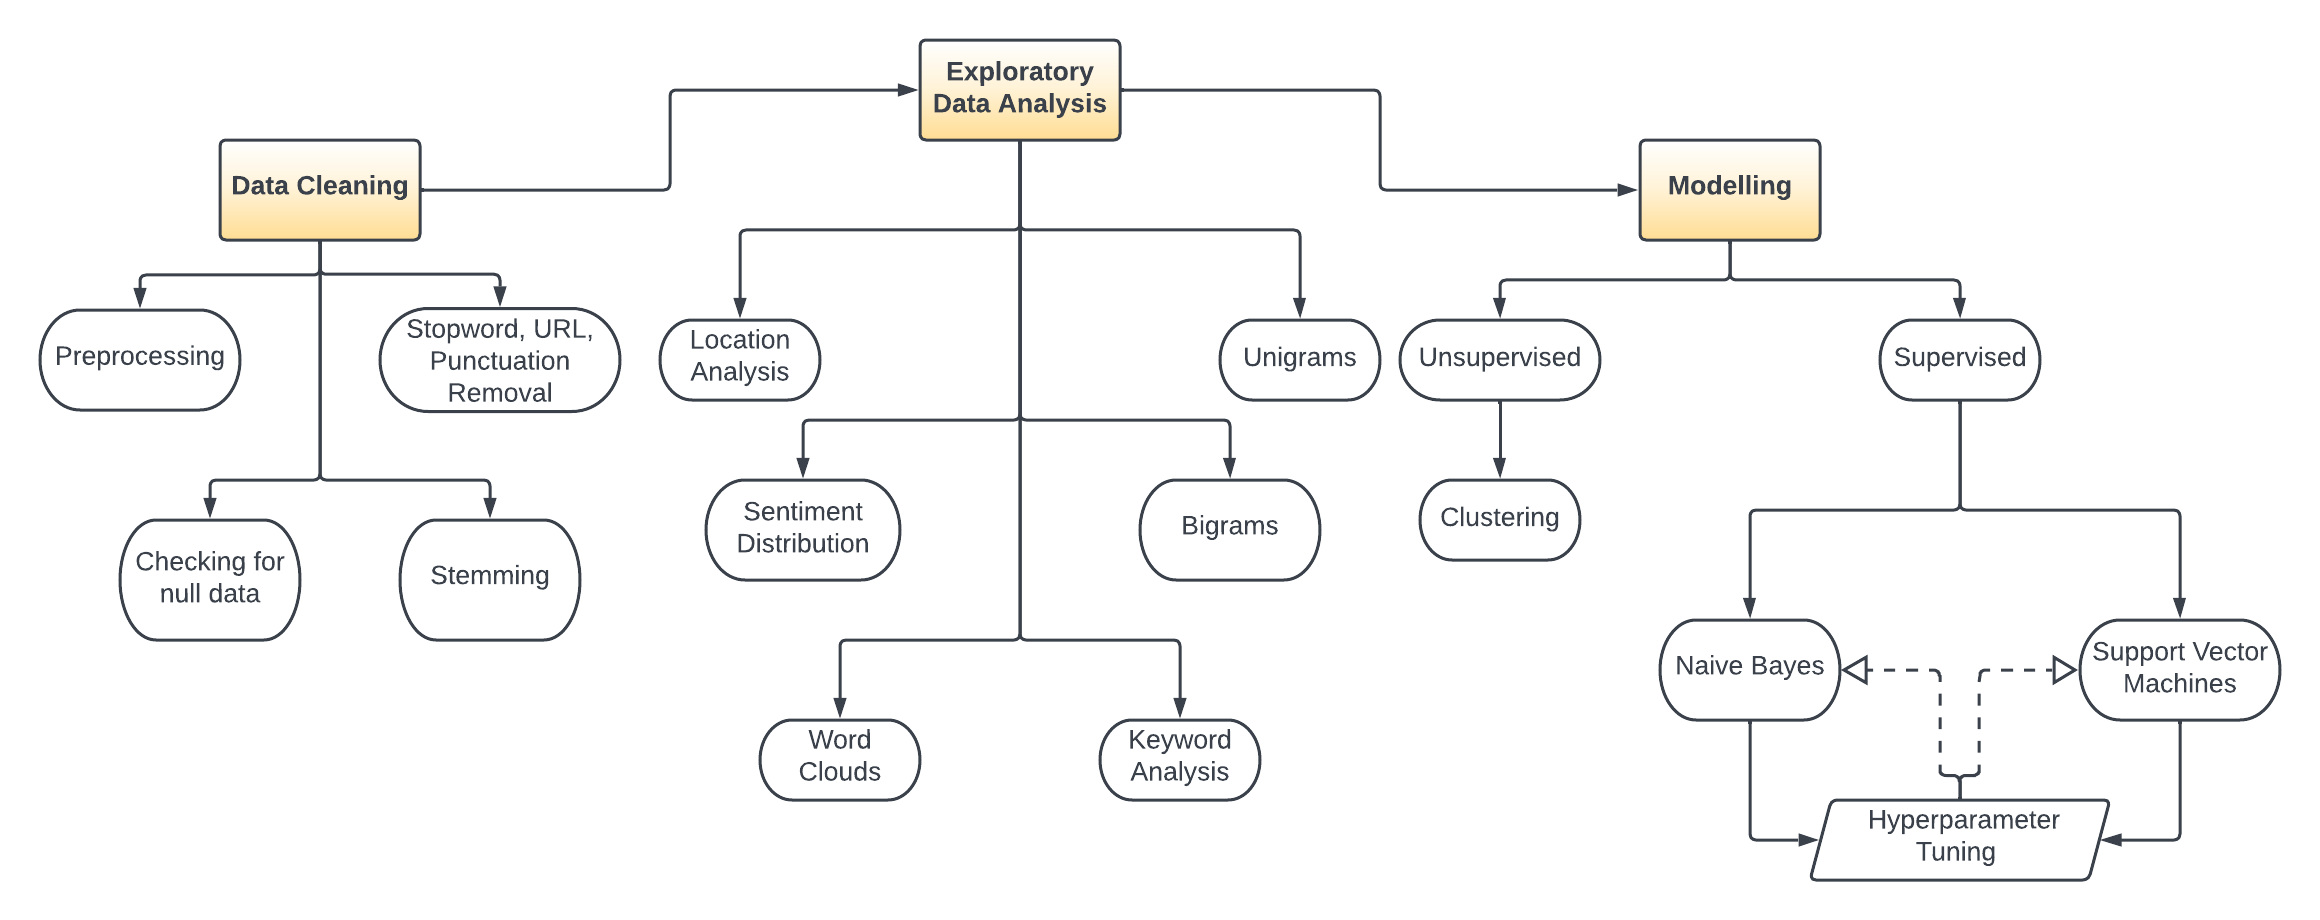

## **Reading the datasets**

In [3]:
train_df = pd.read_csv('/content/drive/MyDrive/Capstone/archive/Corona_NLP_train.csv', encoding='latin-1')
train_df.head()

UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative

In [4]:
test_df = pd.read_csv('/content/drive/MyDrive/Capstone/archive/Corona_NLP_test.csv', encoding='latin-1')
test_df.head()

UserName  ScreenName             Location     TweetAt  \
0         1       44953                  NYC  02-03-2020   
1         2       44954          Seattle, WA  02-03-2020   
2         3       44955                  NaN  02-03-2020   
3         4       44956          Chicagoland  02-03-2020   
4         5       44957  Melbourne, Victoria  03-03-2020   

                                       OriginalTweet           Sentiment  
0  TRENDING: New Yorkers encounter empty supermar...  Extremely Negative  
1  When I couldn't find hand sanitizer at Fred Me...            Positive  
2  Find out how you can protect yourself and love...  Extremely Positive  
3  #Panic buying hits #NewYork City as anxious sh...            Negative  
4  #toiletpaper #dunnypaper #coronavirus #coronav...             Neutral

In [5]:
df = pd.concat([train_df,test_df])

## **Visualizing Data**

In [6]:
sentiment = train_df["Sentiment"].value_counts()
fig = px.pie(values=sentiment.values, 
             names=sentiment.index,
             color_discrete_sequence=px.colors.sequential.Blues)
fig.update_traces(textposition='inside',
                  textfont_size=11,
                  textinfo='percent+label')
fig.update_layout(title_text="Sentiment Distribution",
                  uniformtext_minsize=12, 
                  uniformtext_mode='hide')

fig.show()

In [7]:
train_df[['TweetAt']] = train_df[['TweetAt']].apply(pd.to_datetime)

<ipython-input-7-d355bb9ebdf9>:1: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.



In [8]:
train_df['TweetAt'] = pd.to_datetime(train_df.TweetAt, format='%Y/%m/%d')
train_df['TweetAt'] = train_df['TweetAt'].dt.strftime('%Y/%m/%d')

In [9]:
location = train_df['Location'].value_counts()[:10]
fig = px.bar(x=location.index,y=location.values,text=location.values,
       color = location.index, color_discrete_sequence=px.colors.sequential.deep,
        title = 'Top 10 Locations',
        template = 'simple_white')
fig.update_traces(textposition='inside',
                  textfont_size=11)
fig.show()

In [10]:
train_df['text'] = train_df.OriginalTweet
train_df["text"] = train_df["text"].astype(str)

In [11]:
class_df = train_df.groupby('Sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)

<Axes: xlabel='Mentions', ylabel='count'>

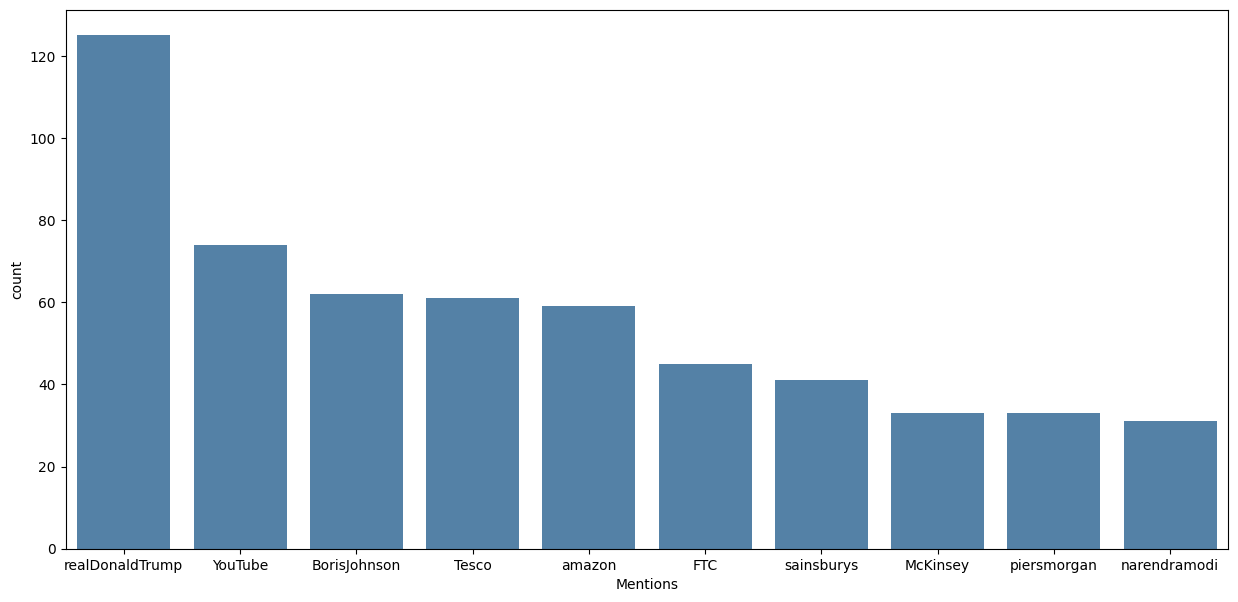

In [12]:
def mentions(text):
    line=re.findall(r'(?<=@)\w+',text)
    return " ".join(line)

train_df['mentions'] = train_df['text'].apply(lambda x:mentions(x))

temp = train_df['mentions'].value_counts()[:][1:11]
temp = temp.to_frame().reset_index().rename(columns={'index':'Mentions','mentions':'count'})

plt.figure(figsize=[15,7])
sns.barplot(x="Mentions",y="count", data = temp, color='steelblue')

In [13]:
df.isnull().sum()
# 21% of the data has null locations

UserName            0
ScreenName          0
Location         9424
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [14]:
print('Total distinct tweets:',(df.shape[0]))
print('Total distinct Users:',(df['UserName'].nunique()))
# There are 44,955 distinct users with their respective distinct tweets

Total distinct tweets: 44955
Total distinct Users: 44955


To check the distribution of tweets with for each sentiment

In [15]:
def clean_review(text):
  
    '''
    Def: This function cleans the text data by removing punctuations, stopwords, urls and doing stemming
    Params:
      text: a string containing a text data
    Return:
      review_cleaned: a cleaned/processed text data
    '''
    
    text1=re.sub(" +"," ",text)
    text2=re.sub(r'[^\w\s]','',text1)
    text3=re.sub(r'http\S+','',text2)
    text4=re.sub("[^A-Za-z0-9.]+"," ",text3)
    text5=text4.lower()
    tokens=word_tokenize(text5)
    stop_words=set(stopwords.words('english')+['coronavirus','covid19','outbreak','corona','covid','19','virus'])
    new_review=[i for i in tokens if not i in stop_words] 
    ps=PorterStemmer()
    new_rev = [ps.stem(word) for word in new_review]
    review_cleaned=' '.join(word for word in new_rev)
    
    return review_cleaned

In [16]:
df['OriginalTweet'] = df['OriginalTweet'].apply(clean_review)

In [17]:
def wordcloud_create(df,color,text):

  '''
    Def: This function returns the wordclouds generated for given dataframe in given color with given text as heading
    Params:
      df: dataframe containing tweets to use to make wordcloud
      color: color that you want to plot
      text: heading of the plot
    Return:
      This function returns the wordclouds generated for given dataframe in given color 
    '''
    
  fig, ax1 = plt.subplots(1, 1, figsize=[20, 10])
  comment_words = '' 
  stopwords = set(STOPWORDS)
  for val in df.OriginalTweet: 
 
    tokens = str(val).split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 

    comment_words += " ".join(tokens)+" "
   
  wordcloud1 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap=color,
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

  ax1.imshow(wordcloud1)
  ax1.axis('off')
  ax1.set_title(text,fontsize=35);

In [18]:
def generate_unigrams(text, n_gram=1):
    
    '''
    Def: This function returns the unigrams created for the given text data
    Params:
      text: the text data we use to create ngrams
      n_gram: number of grams, by default its 1
    Return:
      This function returns the unigrams created for the given text data
    '''

    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

def graph_unigram(N,data,color):
   
  '''
    Def: This function plots the top N unigrams in the plot using given color for given data 
    Params:
      N: number of top unigrams that we want to see in plot
      data: the text data that we want to use for creating unigrams and plot
      color: color that you want to plot
    Return:
      This function plots the top N unigrams in the plot using given color for given data 
  '''

  unigrams = defaultdict(int)

  for tweet in df[data]['OriginalTweet']:
    for word in generate_unigrams(tweet):
        unigrams[word] += 1

  df_unigrams = pd.DataFrame(sorted(unigrams.items(), key=lambda x: x[1])[::-1])

  fig, axes = plt.subplots(1,1, figsize=(15, 15), dpi=40)
  plt.tight_layout()

  sns.barplot(y=df_unigrams[0].values[:N], x=df_unigrams[1].values[:N], ax=axes, color=color)

  axes.spines['right'].set_visible(False)
  axes.set_xlabel('')
  axes.set_ylabel('')
  axes.tick_params(axis='x', labelsize=13)
  axes.tick_params(axis='y', labelsize=13)

  axes.set_title(f'Top {N} most common unigrams in Tweets', fontsize=15)

  plt.show()

In [19]:
def generate_bigrams(text, n_gram=2):

    '''
    Def: This function returns the biigrams created for the given text data
    Params:
      text: the text data we use to create ngrams
      n_gram: number of grams, by default its 2
    Return:
      This function returns the biigrams created for the given text data
    '''

    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

def graph_bigram(N,data,color):

  '''
    Def: This function plots the top N bigrams in the plot using given color for given data 
    Params:
      N: number of top bigrams that we want to see in plot
      data: the text data that we want to use for creating bigrams and plot
      color: color that you want to plot
    Return:
      This function plots the top N bigrams in the plot using given color for given data 
  '''

  bigrams = defaultdict(int)

  for tweet in df[data]['OriginalTweet']:
    for word in generate_bigrams(tweet):
        bigrams[word] += 1

  df_bigrams = pd.DataFrame(sorted(bigrams.items(), key=lambda x: x[1])[::-1])

  fig, axes = plt.subplots(1,1, figsize=(15, 15), dpi=40)
  plt.tight_layout()

  sns.barplot(y=df_bigrams[0].values[:N], x=df_bigrams[1].values[:N], ax=axes, color=color)

  axes.spines['right'].set_visible(False)
  axes.set_xlabel('')
  axes.set_ylabel('')
  axes.tick_params(axis='x', labelsize=13)
  axes.tick_params(axis='y', labelsize=13)

  axes.set_title(f'Top {N} most common bigrams in Tweets', fontsize=15)

  plt.show()

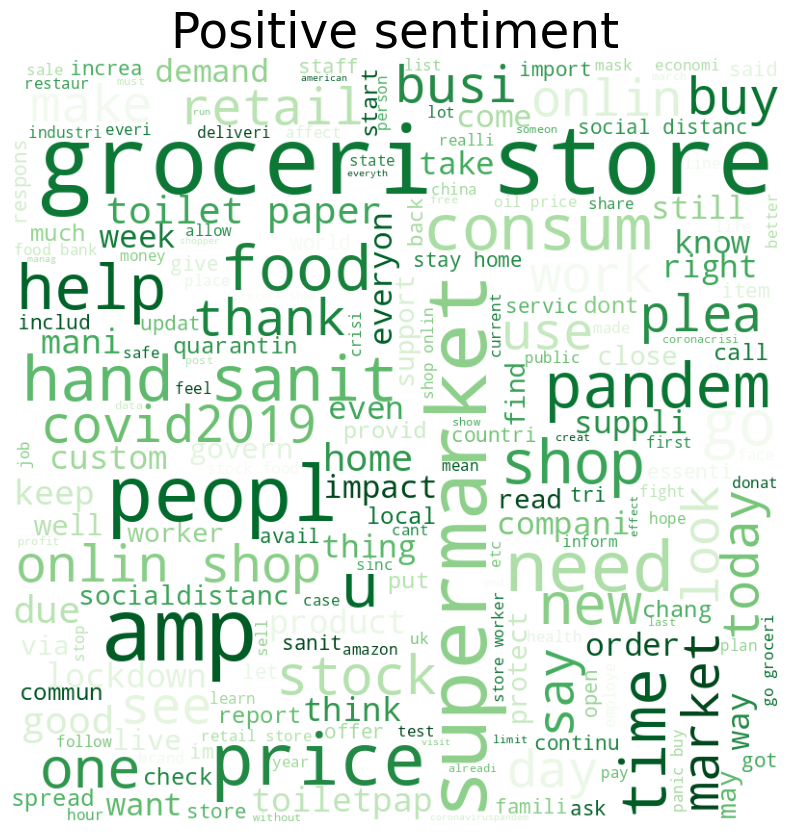

In [20]:
df_pos = df[df["Sentiment"]=="Positive"]
wordcloud_create(df_pos,"Greens","Positive sentiment")

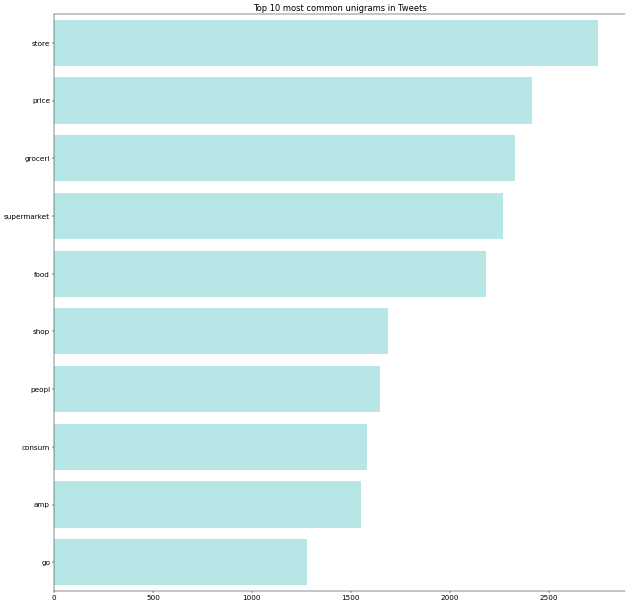

In [21]:
positive= df["Sentiment"]== "Positive"
graph_unigram(10,positive,'paleturquoise')

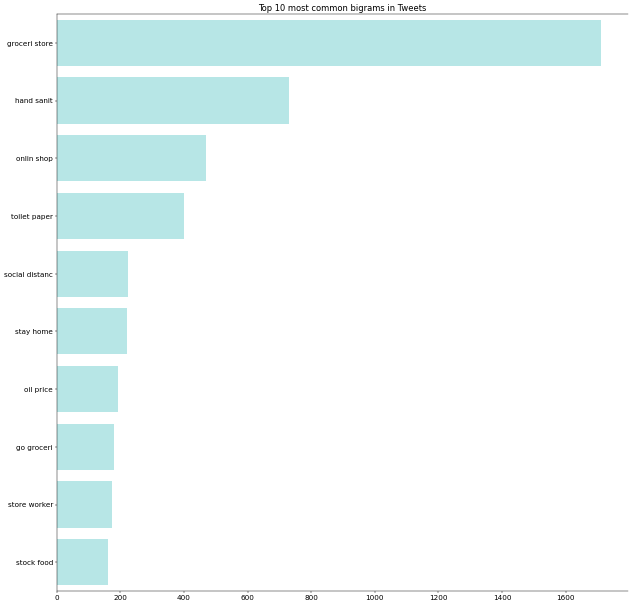

In [22]:
positive= df["Sentiment"]== "Positive"
graph_bigram(10,positive,'paleturquoise')

from the wordcloud, we can see that words like groceri, store, help,need, hand, sanit are 
the top words in positive tweets.
Looking at the unigrams generated from the positive tweets, some top words are store, price,
groceri, supermarket. Now, after analyzing more into positive tweets and looking into
bigrams of the positive tweets, top words are groceri store, hand sanit, onlin shop, social
distanc. It means that people are talking positive about the grocery stores, online shopping
and they are talking more about the hand santitizer and social distance.

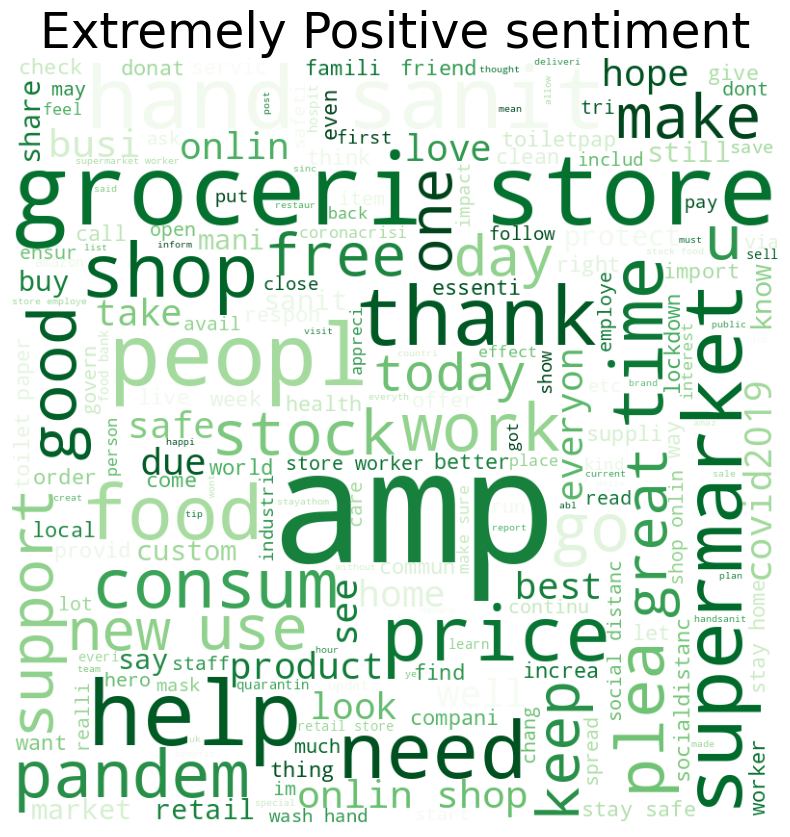

In [23]:
df_ext_pos = df[df["Sentiment"]=="Extremely Positive"]
wordcloud_create(df_ext_pos,"Greens","Extremely Positive sentiment")

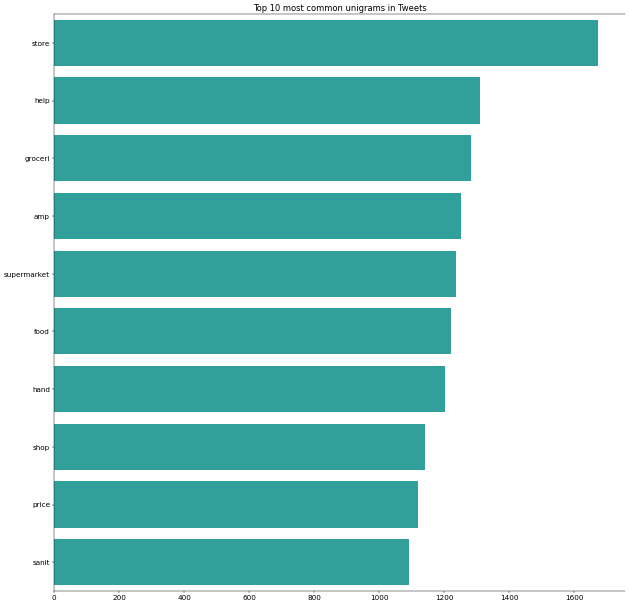

In [24]:
ext_positive= df["Sentiment"]== "Extremely Positive"
graph_unigram(10,ext_positive,'lightseagreen')

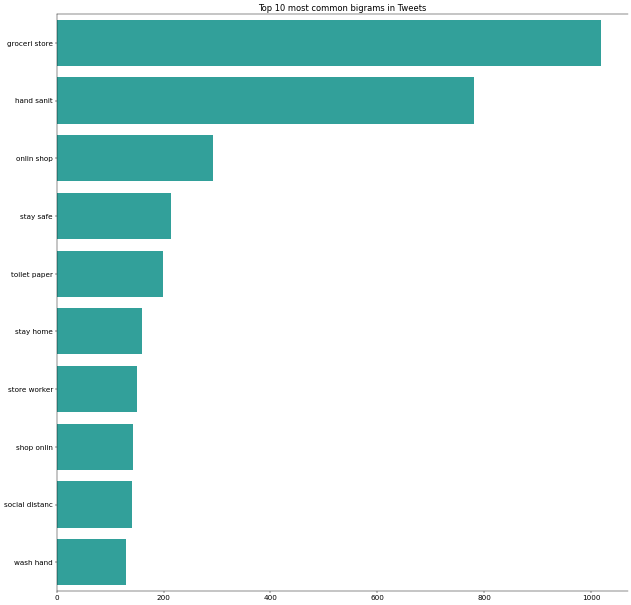

In [25]:
ext_positive= df["Sentiment"]== "Extremely Positive"
graph_bigram(10,ext_positive,'lightseagreen')

from the wordcloud, we can see that words like supermarket, tore, support, great are 
the top words in extremely positive tweets.
Looking at the unigrams generated from the extremely positive tweets, some top words are store, help,
groceri, amp. Now, after analyzing more into extremely positive tweets and looking into
bigrams of those tweets, top words are groceri store, hand sanit, onlin shop, stay safe. It means that people are talking positive about the grocery stores, online shopping
and they are talking more about the hand santitizer and staying safe.
As you can notice the top words in positive tweet and extremely positive tweet are almost similar.
Hence, in further analysis we can make those 2 sentiments into 1 sentiment as positive

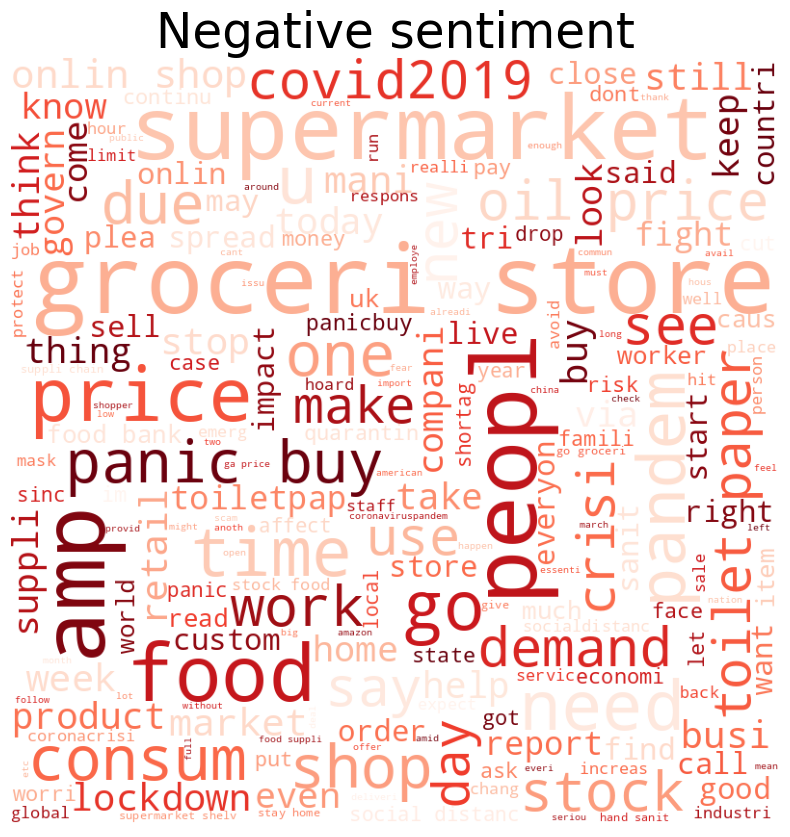

In [26]:
df_neg = df[df["Sentiment"]=="Negative"]
wordcloud_create(df_neg,"Reds","Negative sentiment")

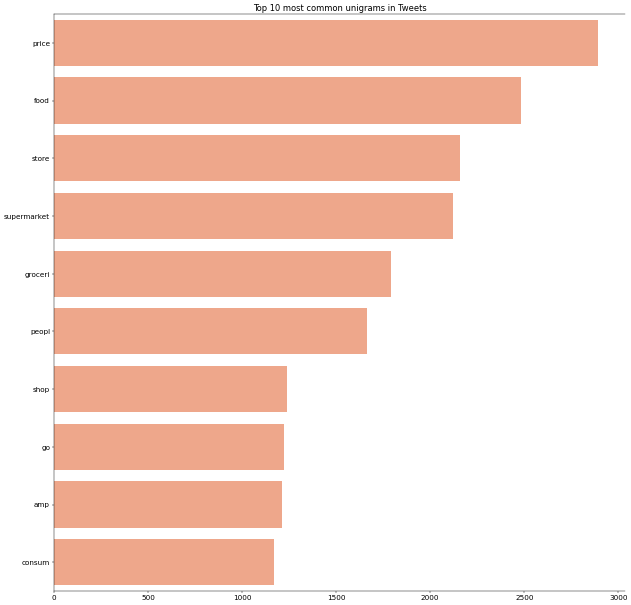

In [27]:
negative= df["Sentiment"]== "Negative"
graph_unigram(10,negative,'lightsalmon')

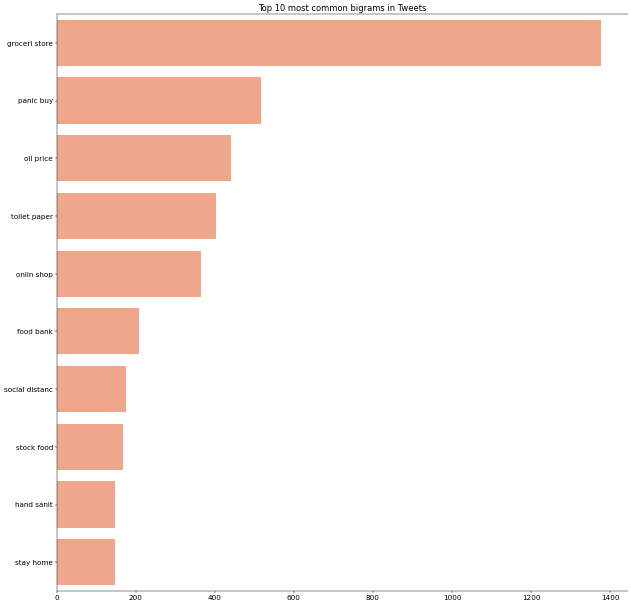

In [28]:
negative= df["Sentiment"]== "Negative"
graph_bigram(10,negative,'lightsalmon')

from the wordcloud, we can see that words like groceri, supermarket, toilet paper,
 demand,panic, consum are 
the top words in negative tweets.
Looking at the unigrams generated from the negative tweets, some top words are store, price,
food, supermarket. Now, after analyzing more into negative tweets and looking into
bigrams of the negative tweets, top words are groceri store, panic buy, oil price, food bank.
 It means that people are talking negative about the grocery stores, food bank
and they are talking more about the panic buy and oil price.

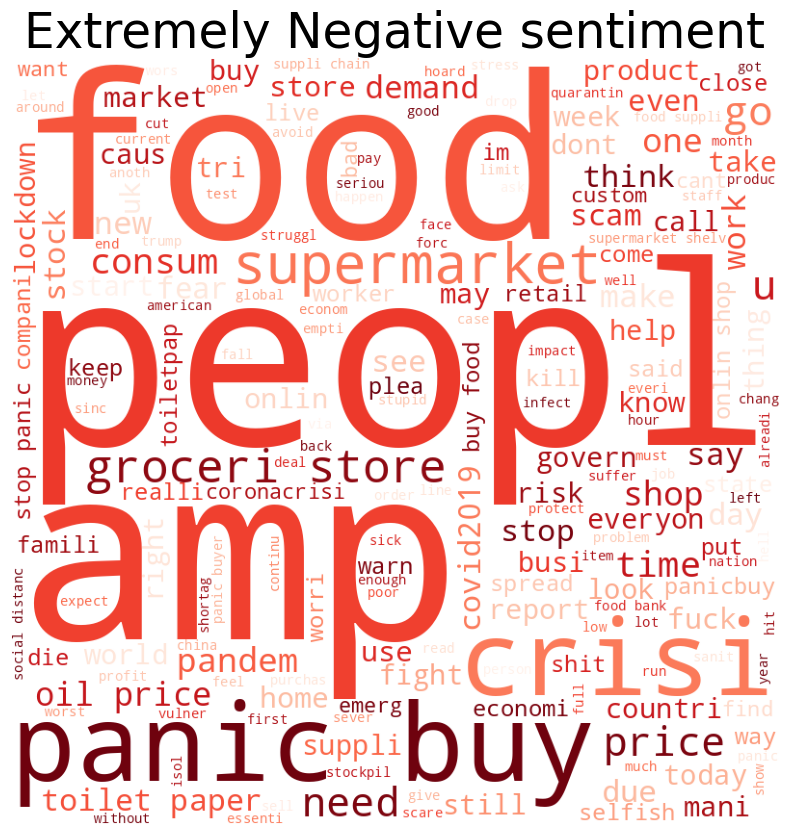

In [29]:
df_ext_neg = df[df["Sentiment"]=="Extremely Negative"]
wordcloud_create(df_ext_neg,"Reds","Extremely Negative sentiment")

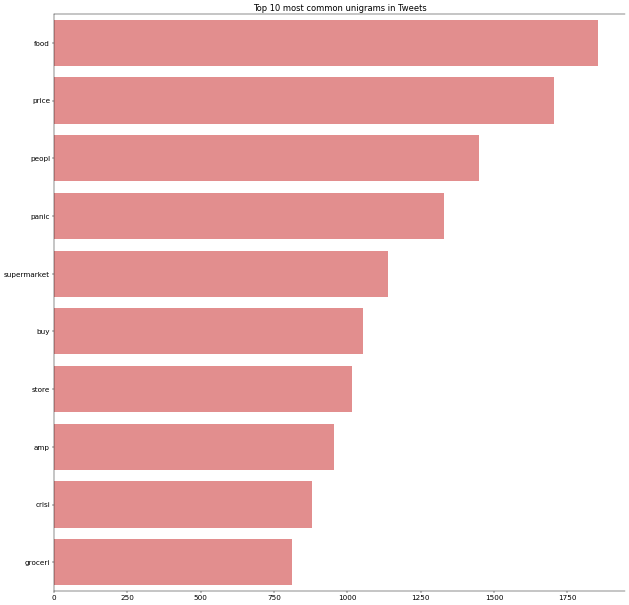

In [30]:
ext_negative= df["Sentiment"]== "Extremely Negative"
graph_unigram(10,ext_negative,'lightcoral')

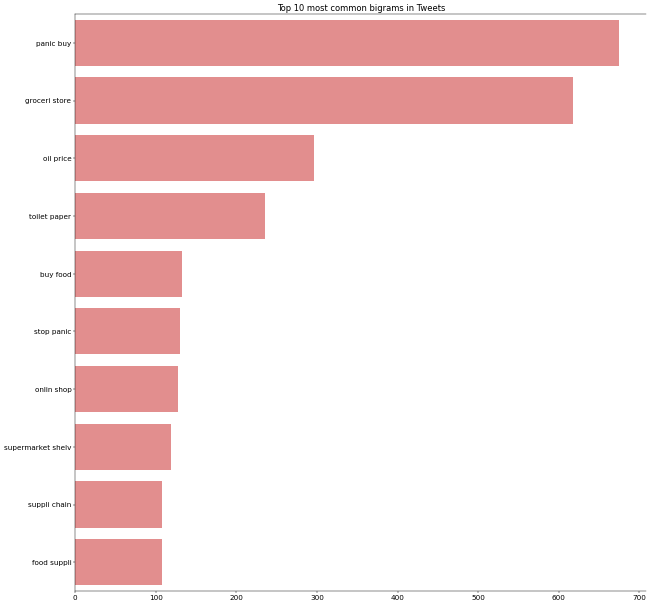

In [31]:
ext_negative= df["Sentiment"]== "Extremely Negative"
graph_bigram(10,ext_negative,'lightcoral')

from the wordcloud, we can see that words like supermarket, foods, people, amp are 
the top words in extremely negative tweets.
Looking at the unigrams generated from the extremely negative tweets, some top words are food, price,
people, panic. Now, after analyzing more into extremely negative tweets and looking into
bigrams of those tweets, top words are groceri store, oil price, toilet paper, buy food. It means that people are talking positive about the grocery stores, online shopping
and they are talking more about the grocery store grocery store and buying food.
As you can notice the top words in negative tweet and extremely negative tweet are almost similar.
Hence, in further analysis we can make those 2 sentiments into 1 sentiment as negative

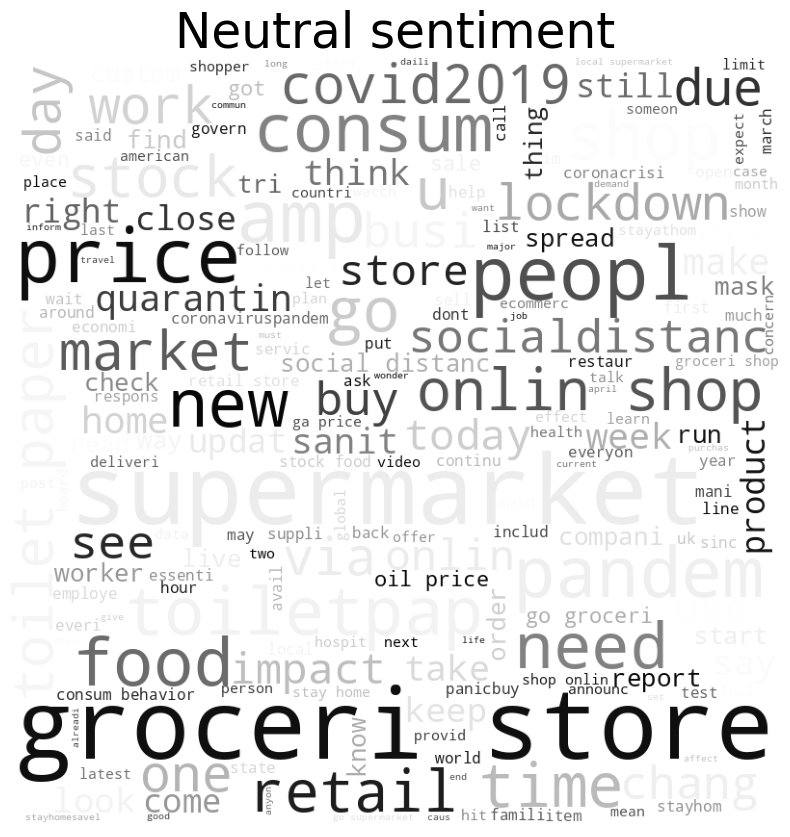

In [32]:
df_net = df[df["Sentiment"]=="Neutral"]
wordcloud_create(df_net,"Greys","Neutral sentiment")

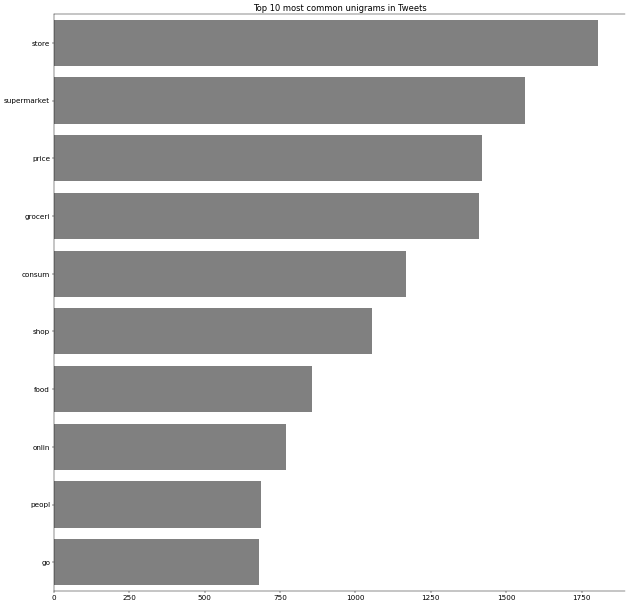

In [33]:
neutral= df["Sentiment"]== "Neutral"
graph_unigram(10,neutral,'grey')

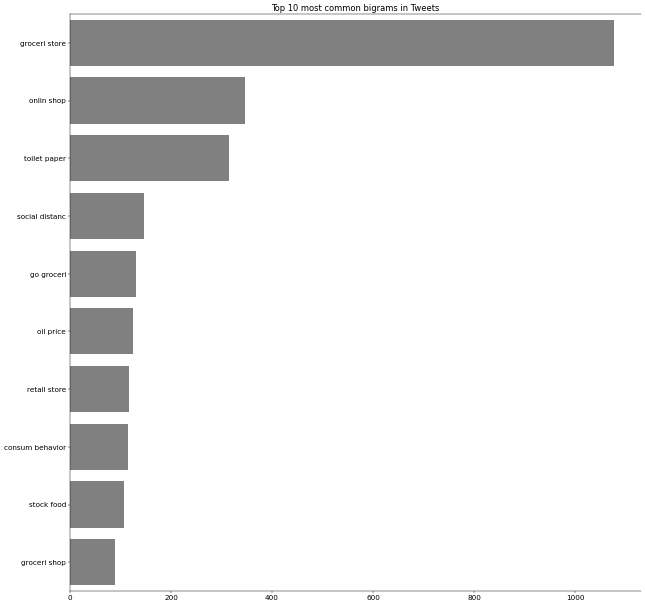

In [34]:
neutral= df["Sentiment"]== "Neutral"
graph_bigram(10,neutral,'grey')

from the wordcloud, we can see that words like groceri, supermarket, store,
 retail,time are 
the top words in neutral tweets.
Looking at the unigrams generated from the neutral tweets, some top words are store, supermarket,
price, groceri. Now, after analyzing more into neutral tweets and looking into
bigrams of the neutral tweets, top words are groceri store, online shop, toilet paper, oil price.
 It means that people are talking neutral about the grocery stores, toilet paper
and they are talking more about online shopping and oil price.

In [35]:
train_df['Sentiment'] = train_df['Sentiment'].map({'Extremely Positive':'Positive', 'Extremely Negative':'Negative', 'Negative':'Negative', 'Positive':'Positive', 'Neutral':'Neutral'})
train_data = train_df[['OriginalTweet', 'Sentiment']]

In [36]:
neg = train_data[train_data['Sentiment']=='Negative']['OriginalTweet'].apply(lambda x: len(set(str(x).split()))).to_list()
pos = train_data[train_data['Sentiment']=='Positive']['OriginalTweet'].apply(lambda x: len(set(str(x).split()))).to_list()
neu = train_data[train_data['Sentiment']=='Neutral']['OriginalTweet'].apply(lambda x: len(set(str(x).split()))).to_list()

fig = ff.create_distplot([neg, pos, neu], ['Negative', 'Positive', 'Neutral'])
fig.update_layout(title_text="Unique Word Count Distribution")
iplot(fig)

In [37]:
# Aggregate the data by region and compute the sum of the desired column
agg_df = train_df.groupby(['Location']).sum()

# Create the choropleth map
fig = px.choropleth(agg_df, locations=['Location'], color=['Sentiment'])

# Show the map
fig.show()

<ipython-input-37-bb04029d7235>:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



## Text clustering

In [38]:
# generating tf-idf vectors for the text

cv = CountVectorizer()
X = cv.fit(df['OriginalTweet'])
X_transform = X.transform(df['OriginalTweet'])
tfidf = TfidfTransformer()
transformer = tfidf.fit(X_transform)
X = transformer.transform(X_transform)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



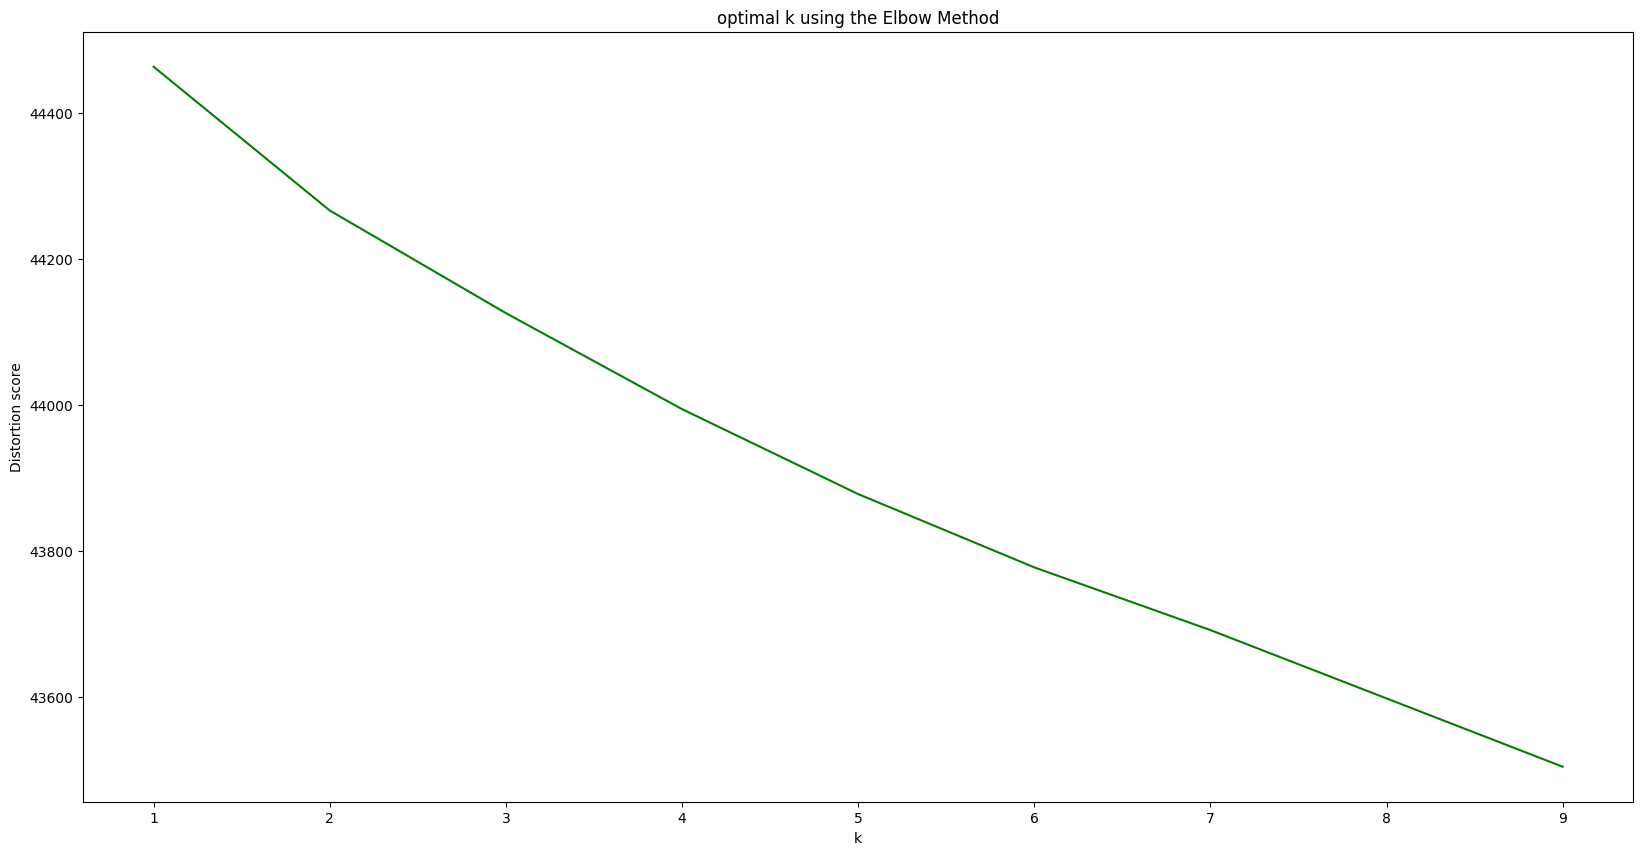

In [39]:
from seaborn.distributions import distplot
#plotting elbow graph to identify optimum clusters
from sklearn.cluster import KMeans
dist = []
K = range(1,10)
for k in K:
    kmeans= KMeans(n_clusters=k,random_state=7)
    kmeans.fit(X)
    dist.append(kmeans.inertia_)
    
plt.figure(figsize=(20,10))
plt.plot(K, dist, '-',color='g')
plt.xlabel('k')
plt.ylabel('Distortion score')
plt.title('optimal k using the Elbow Method')
plt.show()

no clear difference observed in distortion trend at any value of k

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

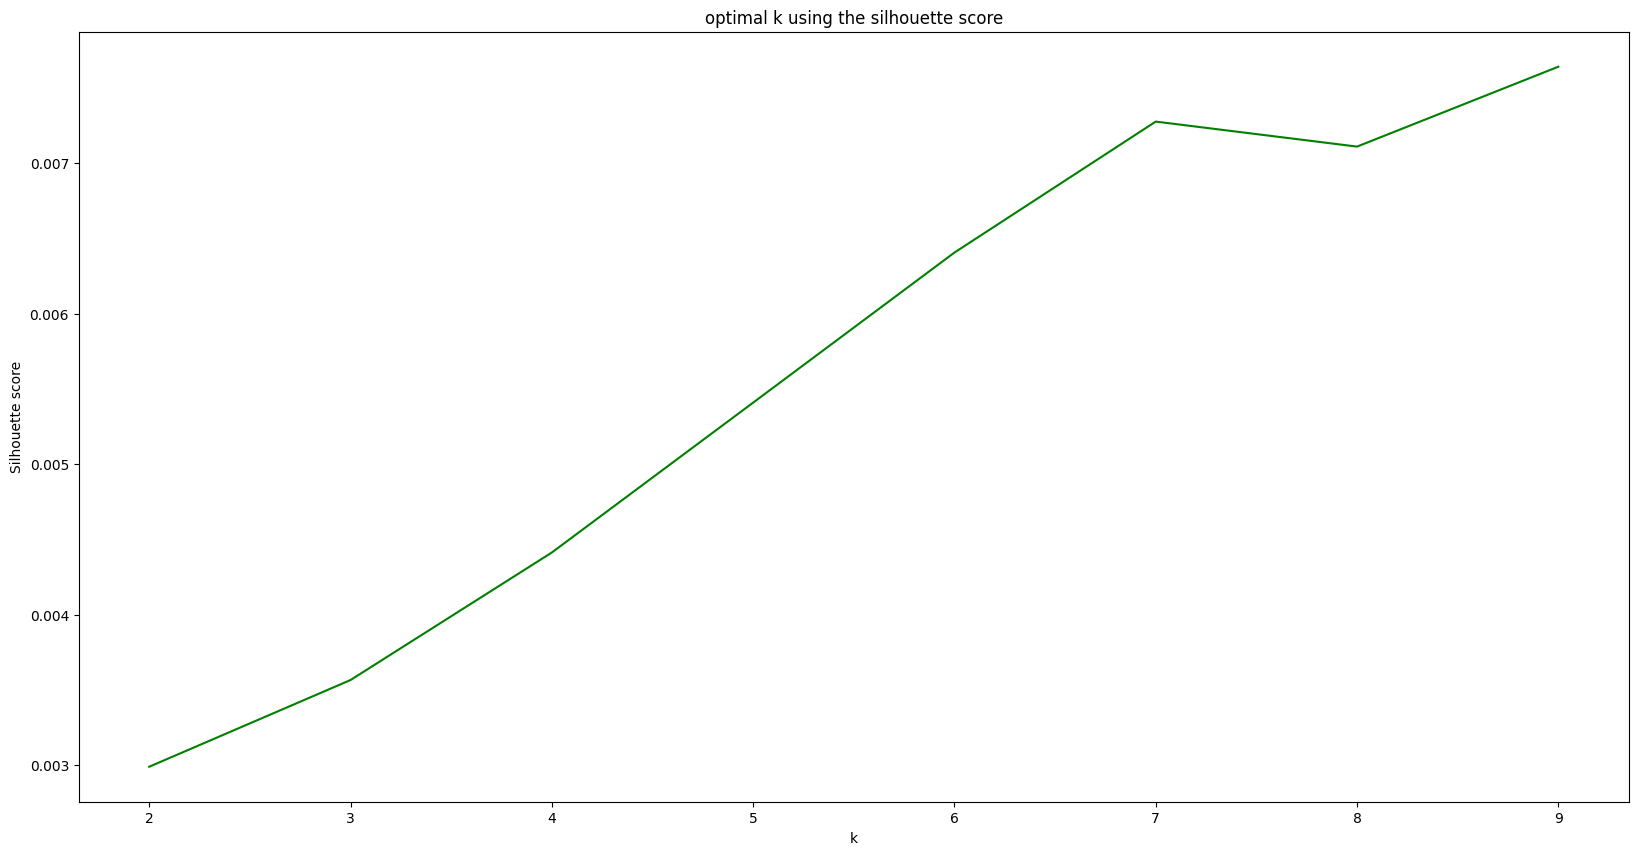

In [40]:
# plotting silhouette scores to identify optimum no. of clusters
from sklearn.metrics import silhouette_score
K = range(2,10)
silhouette = []
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    preds = kmeans.predict(X)
    silhouette.append(silhouette_score(X, preds))
    
plt.figure(figsize=(20,10))
plt.plot(K, silhouette, '-',color='g')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('optimal k using the silhouette score')
plt.show()

silhouette scores too small to be significant

In [41]:
# performing t-SNE for dimensionality reduction
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, init="random")
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 44955 samples in 0.004s...
[t-SNE] Computed neighbors for 44955 samples in 700.765s...
[t-SNE] Computed conditional probabilities for sample 1000 / 44955
[t-SNE] Computed conditional probabilities for sample 2000 / 44955
[t-SNE] Computed conditional probabilities for sample 3000 / 44955
[t-SNE] Computed conditional probabilities for sample 4000 / 44955
[t-SNE] Computed conditional probabilities for sample 5000 / 44955
[t-SNE] Computed conditional probabilities for sample 6000 / 44955
[t-SNE] Computed conditional probabilities for sample 7000 / 44955
[t-SNE] Computed conditional probabilities for sample 8000 / 44955
[t-SNE] Computed conditional probabilities for sample 9000 / 44955
[t-SNE] Computed conditional probabilities for sample 10000 / 44955
[t-SNE] Computed conditional probabilities for sample 11000 / 44955
[t-SNE] Computed conditional probabilities for sample 12000 / 44955
[t-SNE] Computed conditional probabilities for 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

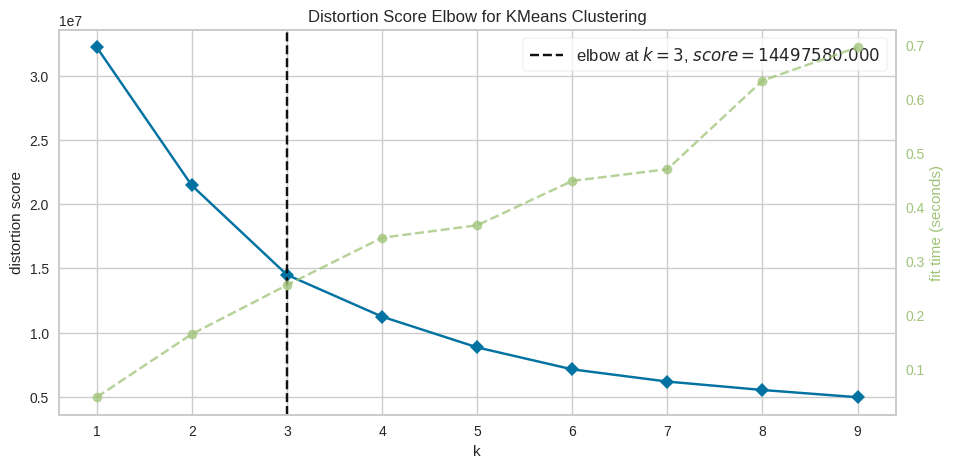

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [42]:
from yellowbrick.cluster.elbow import KElbowVisualizer

kmeans = KMeans()
plot = KElbowVisualizer(kmeans, k=(1,10),size=(1080, 500))
plot.fit(tsne_results)        
plot.show()

elbow observed at K = 3

In [43]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(tsne_results)
pred_labels = kmeans.labels_;
pred_centers = kmeans.cluster_centers_
df_centers = pd.DataFrame(pred_centers, columns=['x', 'y'])
df_centers.head(1)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



x          y
0 -11.973431 -12.071359

In [44]:
df_label = pd.DataFrame(columns=['x','y','label'])
df_label['x'] = tsne_results[:,0]
df_label['y'] = tsne_results[:,1]
df_label['label'] = kmeans.labels_
df_label.head(1)

x          y  label
0 -34.542652  10.304687      0

Text(0, 0.5, 'y')

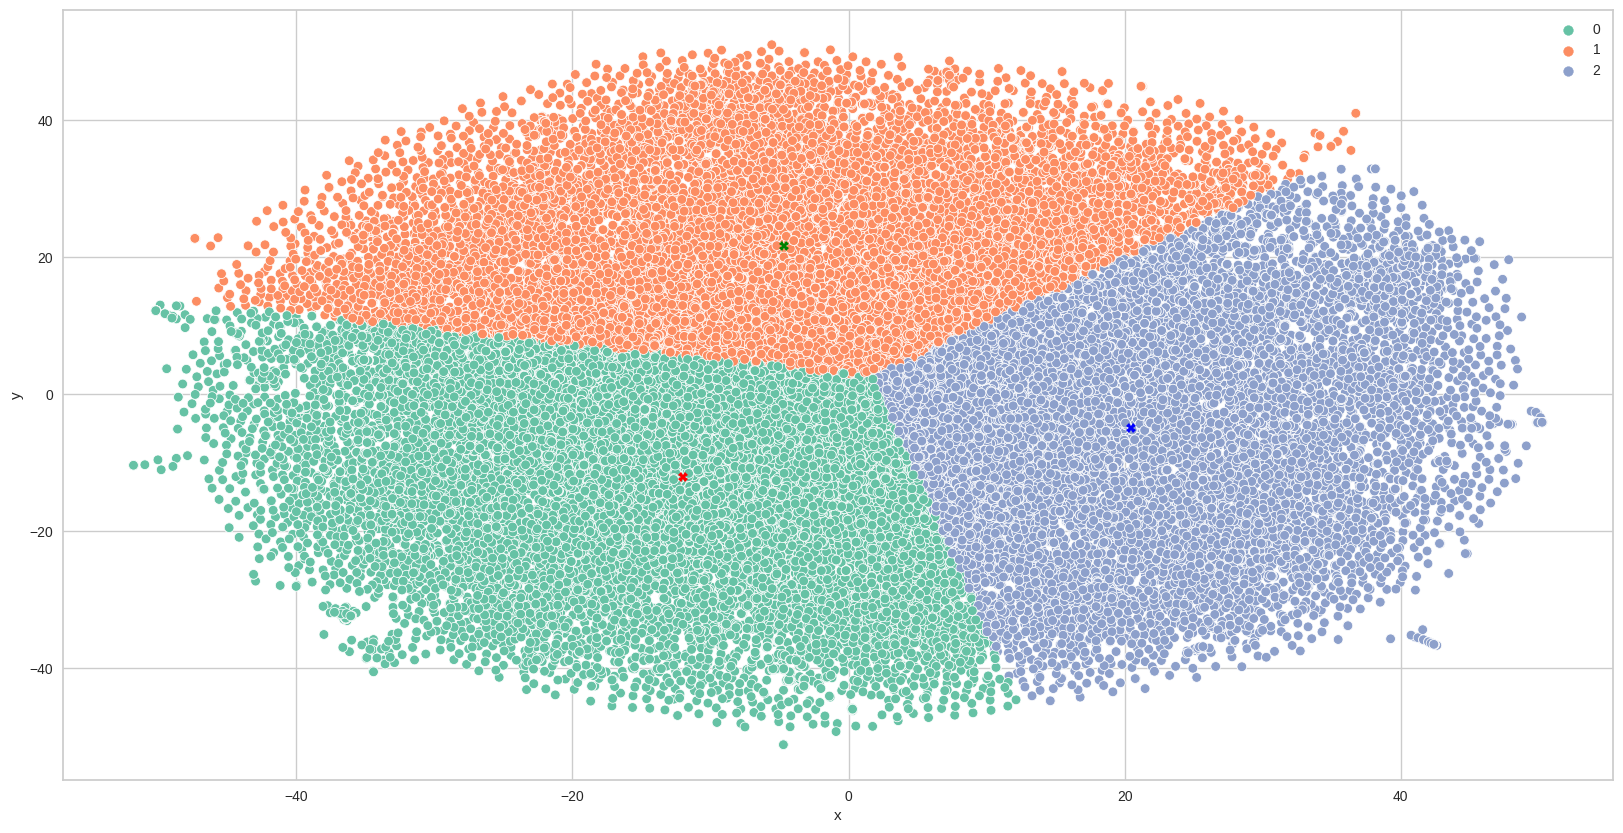

In [56]:
#plotting clusters
import seaborn as sns

p = plt.figure(figsize=(20,10))
p = sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=pred_labels.tolist(), palette='Set2', data=tsne_results)
#p = sns.scatterplot(tsne_results[:, 0], tsne_results[:, 1], hue=pred_labels.tolist(),palette='Set2')
colors = ['red', 'green', 'blue', 'yellow']

for i,color in enumerate(df_centers.index.tolist()):
    plt.plot(df_centers['x'][i], df_centers['y'][i], 'X', label='K-means center: %d' % i, color=colors[i])
plt.xlabel('x')
plt.ylabel('y')

from the plot the clusters appear to be almost equally present in the dataset implying uniform distribution

In [57]:
# defining helper functions
def get_string(tweet):
    sentence = ''
    for words in tweet:
        sentence += words
    sentence = sentence.lower()
    return sentence


def get_words(text): 
    result = nltk.RegexpTokenizer(r'\w+').tokenize(text.lower())
    return result


def get_freq(cleanwordlist):
    Freq_dist_nltk = nltk.FreqDist(cleanwordlist)
    df_freq = pd.DataFrame.from_dict(Freq_dist_nltk, orient='index')
    df_freq.columns = ['Frequency']
    df_freq.index.name = 'Term'
    df_freq = df_freq.sort_values(by=['Frequency'],ascending=False)
    df_freq = df_freq.reset_index()
    return df_freq

In [58]:
# identifying important keywords for each cluster based on their frequency of occurence
df['label'] = pred_labels
df = df[['OriginalTweet','label']]
label0 = df[df['label']==0]
label1 = df[df['label']==1]
label2 = df[df['label']==2]
words0 = get_words(get_string(label0['OriginalTweet']))
words1 = get_words(get_string(label1['OriginalTweet']))
words2 =  get_words(get_string(label2['OriginalTweet']))
df0 = get_freq(words0)
df1 = get_freq(words1)
df2 = get_freq(words2)

In [59]:
import plotly.graph_objects as go
fig = go.Figure(data=[
    go.Bar(name='label0', x=df0['Term'][:20].values, y=df0['Frequency'][:20].values,text=df0['Frequency'][:20].values,marker_color='green'),
    go.Bar(name='label1', x=df1['Term'][:20].values, y=df1['Frequency'][:20].values,text=df0['Frequency'][:20].values,marker_color='orange'),
    go.Bar(name='label1', x=df2['Term'][:20].values, y=df2['Frequency'][:20].values,text=df0['Frequency'][:20].values,marker_color='blue')
])
fig.update_layout(barmode='stack', xaxis_tickangle=-45,title='top 20 frequent terms per clusters', template='simple_white')

fig.show()

1. Label0 is signified by keywords like (price,food, demand, oil) implying the tweets having this label mostly talk about oil supply shortage and increase in prices
2. Label1 is signified by keywords like (store, supermarket, groceri, market) implying the tweets having this label mostly talk about inventory and the associated trends of shortage, and panic among consumers
3. Label2 is signified by keywords like (price, store, sanit, hand) implying the tweets having this label mostly talk about use of precautions and health guidelines


## Model training

In [60]:
df = pd.concat([train_df,test_df])

In [61]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
message = vectorizer.fit_transform(df['OriginalTweet'])
message.shape

(44955, 85044)

In [62]:
#split the data into 80% training and 20% testing
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(message,df.Sentiment,test_size=0.20,random_state=0)

In [63]:
# create and train the Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB().fit(xtrain, ytrain)

In [64]:
# Evaluating the model on the training data set
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
pred = classifier.predict(xtrain)
print(classification_report(ytrain, pred))
print()
print("Confusion Matrix: \n", confusion_matrix(ytrain, pred))
print("Accuracy: \n", accuracy_score(ytrain, pred))

                    precision    recall  f1-score   support

Extremely Negative       0.06      0.00      0.00       456
Extremely Positive       0.33      0.00      0.00       485
          Negative       0.80      0.88      0.84     13109
           Neutral       0.94      0.46      0.62      6649
          Positive       0.77      0.92      0.84     15265

          accuracy                           0.80     35964
         macro avg       0.58      0.45      0.46     35964
      weighted avg       0.80      0.80      0.78     35964


Confusion Matrix: 
 [[    1     0   417     2    36]
 [    0     1    41     5   438]
 [    7     0 11517   102  1483]
 [    7     0  1388  3067  2187]
 [    2     2  1097   103 14061]]
Accuracy: 
 0.7965465465465466


In [65]:
# test data
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
pred = classifier.predict(xtest)
print(classification_report(ytest, pred))
print()
print("Confusion Matrix: \n", confusion_matrix(ytest, pred))
print("Accuracy: \n", accuracy_score(ytest, pred))

                    precision    recall  f1-score   support

Extremely Negative       0.00      0.00      0.00       136
Extremely Positive       0.00      0.00      0.00       114
          Negative       0.66      0.74      0.70      3330
           Neutral       0.69      0.29      0.41      1683
          Positive       0.65      0.79      0.71      3728

          accuracy                           0.66      8991
         macro avg       0.40      0.36      0.36      8991
      weighted avg       0.64      0.66      0.63      8991


Confusion Matrix: 
 [[   0    0  121    0   15]
 [   0    0    8    2  104]
 [   4    0 2469   92  765]
 [   5    2  462  485  729]
 [   0    2  667  121 2938]]
Accuracy: 
 0.655321988655322
